## Import Dependencies and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report,confusion_matrix,mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score

/Users/georgemathew/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/z6/d0zj0b9s1lv9vyh5km30751h0000gn/T/ipykernel_43571/3848052263.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('fetal_health.csv')

## Summarize Data

brief text about section

In [3]:
print('Dataframe shape:\n', df.shape, '\n')

Dataframe shape:
 (2126, 22) 



In [4]:
print('Dataframe head:\n', df.head(), '\n')

Dataframe head:
    baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                

In [5]:
print('Dataframe tail:\n', df.tail(), '\n')

Dataframe tail:
       baseline value  accelerations  fetal_movement  uterine_contractions  \
2121           140.0          0.000           0.000                 0.007   
2122           140.0          0.001           0.000                 0.007   
2123           140.0          0.001           0.000                 0.007   
2124           140.0          0.001           0.000                 0.006   
2125           142.0          0.002           0.002                 0.008   

      light_decelerations  severe_decelerations  prolongued_decelerations  \
2121                  0.0                   0.0                       0.0   
2122                  0.0                   0.0                       0.0   
2123                  0.0                   0.0                       0.0   
2124                  0.0                   0.0                       0.0   
2125                  0.0                   0.0                       0.0   

      abnormal_short_term_variability  mean_value_of_shor

In [6]:
print('Summary statistics for each feature:\n', df.describe())

Summary statistics for each feature:
        baseline value  accelerations  fetal_movement  uterine_contractions  \
count     2126.000000    2126.000000     2126.000000           2126.000000   
mean       133.303857       0.003178        0.009481              0.004366   
std          9.840844       0.003866        0.046666              0.002946   
min        106.000000       0.000000        0.000000              0.000000   
25%        126.000000       0.000000        0.000000              0.002000   
50%        133.000000       0.002000        0.000000              0.004000   
75%        140.000000       0.006000        0.003000              0.007000   
max        160.000000       0.019000        0.481000              0.015000   

       light_decelerations  severe_decelerations  prolongued_decelerations  \
count          2126.000000           2126.000000               2126.000000   
mean              0.001889              0.000003                  0.000159   
std               0.00296

## Visualize Data

brief text about section. boxplots, histograms, violin plots(?)

/Users/georgemathew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyError: 'baseline value'

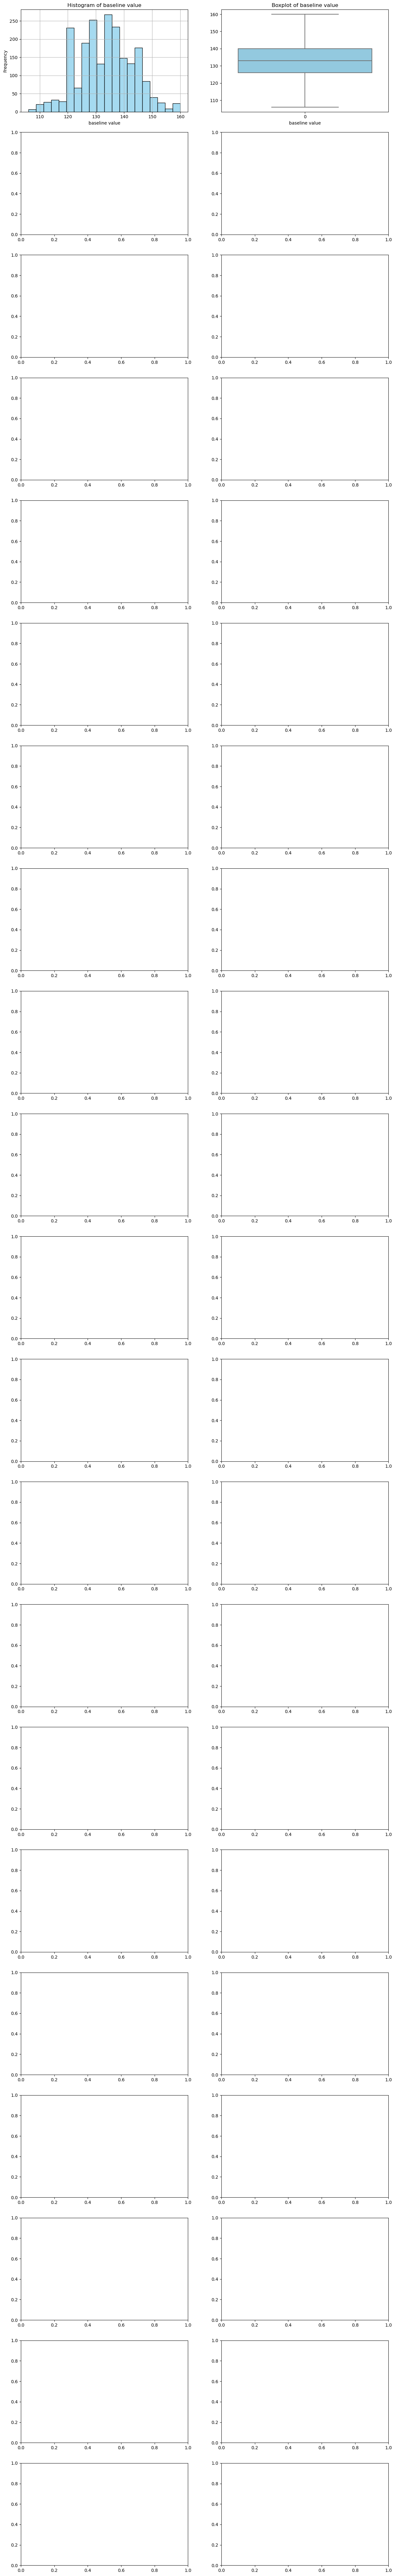

In [7]:
# Histogram and boxplot of each feature
num_features = len(df.columns) - 1
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(15, num_features*5))

unit_dict = {
    'Pregnancies': 'Number of Pregnancies',
    'Glucose': 'Plasma Glucose Concentration(mgmg/dL)',
    'BloodPressure': 'Blood Pressure (mmHg)',
    'SkinThickness': 'Skin Thickness (mm)',
    'Insulin': 'Insulin (mu U/ml)',
    'BMI': 'BMI (kg/m^2)',
    'DiabetesPedigreeFunction': 'DPF',
    'Age': 'Age (yrs)',
}

for i, column in enumerate(df.columns[:-1]):
    # Histogram
    sns.histplot(df[column], bins=20, color='skyblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(True)

    # Boxplot
    sns.boxplot(data=df[column], color='skyblue', ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel(unit_dict[column])  # Set y-axis label using unit_dict
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()
